In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


In [2]:
path_processed = '../data/processed/'
clases = ['basal', 'adelante', 'atras', 'derecha', 'izquierda', 'reposo']

# --- CONFIGURACIÓN ---
# Cambia a None para el primer sujeto, o 2, 3, etc. para otros
sujeto_id =3 

# --- Lógica de Carga Dinámica ---
if sujeto_id is None:
    # Para el primer sujeto, que no tenía identificador en el nombre
    id_archivo = ''
    print("Cargando datos del sujeto original...")
else:
    # Para los nuevos sujetos, creamos un identificador formateado
    # :02d formatea el número a 2 dígitos (ej. 2 -> '02', 10 -> '10')
    id_archivo = f"_sujeto_{sujeto_id:02d}"
    print(f"Cargando datos para el sujeto con id: '{id_archivo}'")

# El diccionario por comprensión ahora es más simple y funciona para ambos casos
dataframes = {clase: pd.read_parquet(f'{path_processed}{clase}_data{id_archivo}.parquet') for clase in clases}

# Verificamos que se cargaron bien
print("Datos cargados exitosamente.")
print(f"Muestras en el segmento 'adelante': {dataframes['adelante'].shape[0]}")

Cargando datos para el sujeto con id: '_sujeto_03'
Datos cargados exitosamente.
Muestras en el segmento 'adelante': 15360


In [3]:
# Identificar las columnas de señales (asumimos que son las mismas en todos los DFs)
signal_cols = [col for col in dataframes['basal'].columns if 'EXG Channel' in col]

# Crear una instancia del escalador
scaler = StandardScaler()

# Iterar sobre cada DataFrame en nuestro diccionario para normalizarlo
for clase, df in dataframes.items():
    print(f"Normalizando el segmento: {clase}")
    
    # Seleccionar solo las columnas de señal
    df_signals = df[signal_cols]
    
    # Ajustar y transformar los datos
    df_scaled_signals = scaler.fit_transform(df_signals)
    
    # Reemplazar las columnas originales con las normalizadas
    df[signal_cols] = df_scaled_signals

print("\n¡Todos los segmentos han sido normalizados!")

Normalizando el segmento: basal
Normalizando el segmento: adelante
Normalizando el segmento: atras
Normalizando el segmento: derecha
Normalizando el segmento: izquierda
Normalizando el segmento: reposo

¡Todos los segmentos han sido normalizados!


In [4]:
def calcular_features_rms_wl(df, window_size=256):
    """
    Toma un DataFrame de señales y calcula RMS y WL para cada canal.
    """
    df_features = df.copy()
    signal_cols = [col for col in df.columns if 'EXG Channel' in col]
    
    print(f"Calculando RMS y WL para {len(signal_cols)} canales...")
    
    for col in signal_cols:
        # --- Calcular RMS (Root Mean Square) ---
        df_features[f'RMS_{col}'] = np.sqrt(
            (df_features[col]**2)
            .rolling(window=window_size, min_periods=1)
            .mean()
        )
        
        # --- Calcular WL (Waveform Length) ---
        diferencias_abs = df_features[col].diff().abs()
        df_features[f'WL_{col}'] = diferencias_abs.rolling(window=window_size, min_periods=1).sum()
        
    print("¡Cálculo completado!")
    return df_features

Calculando RMS y WL para 8 canales...
¡Cálculo completado!


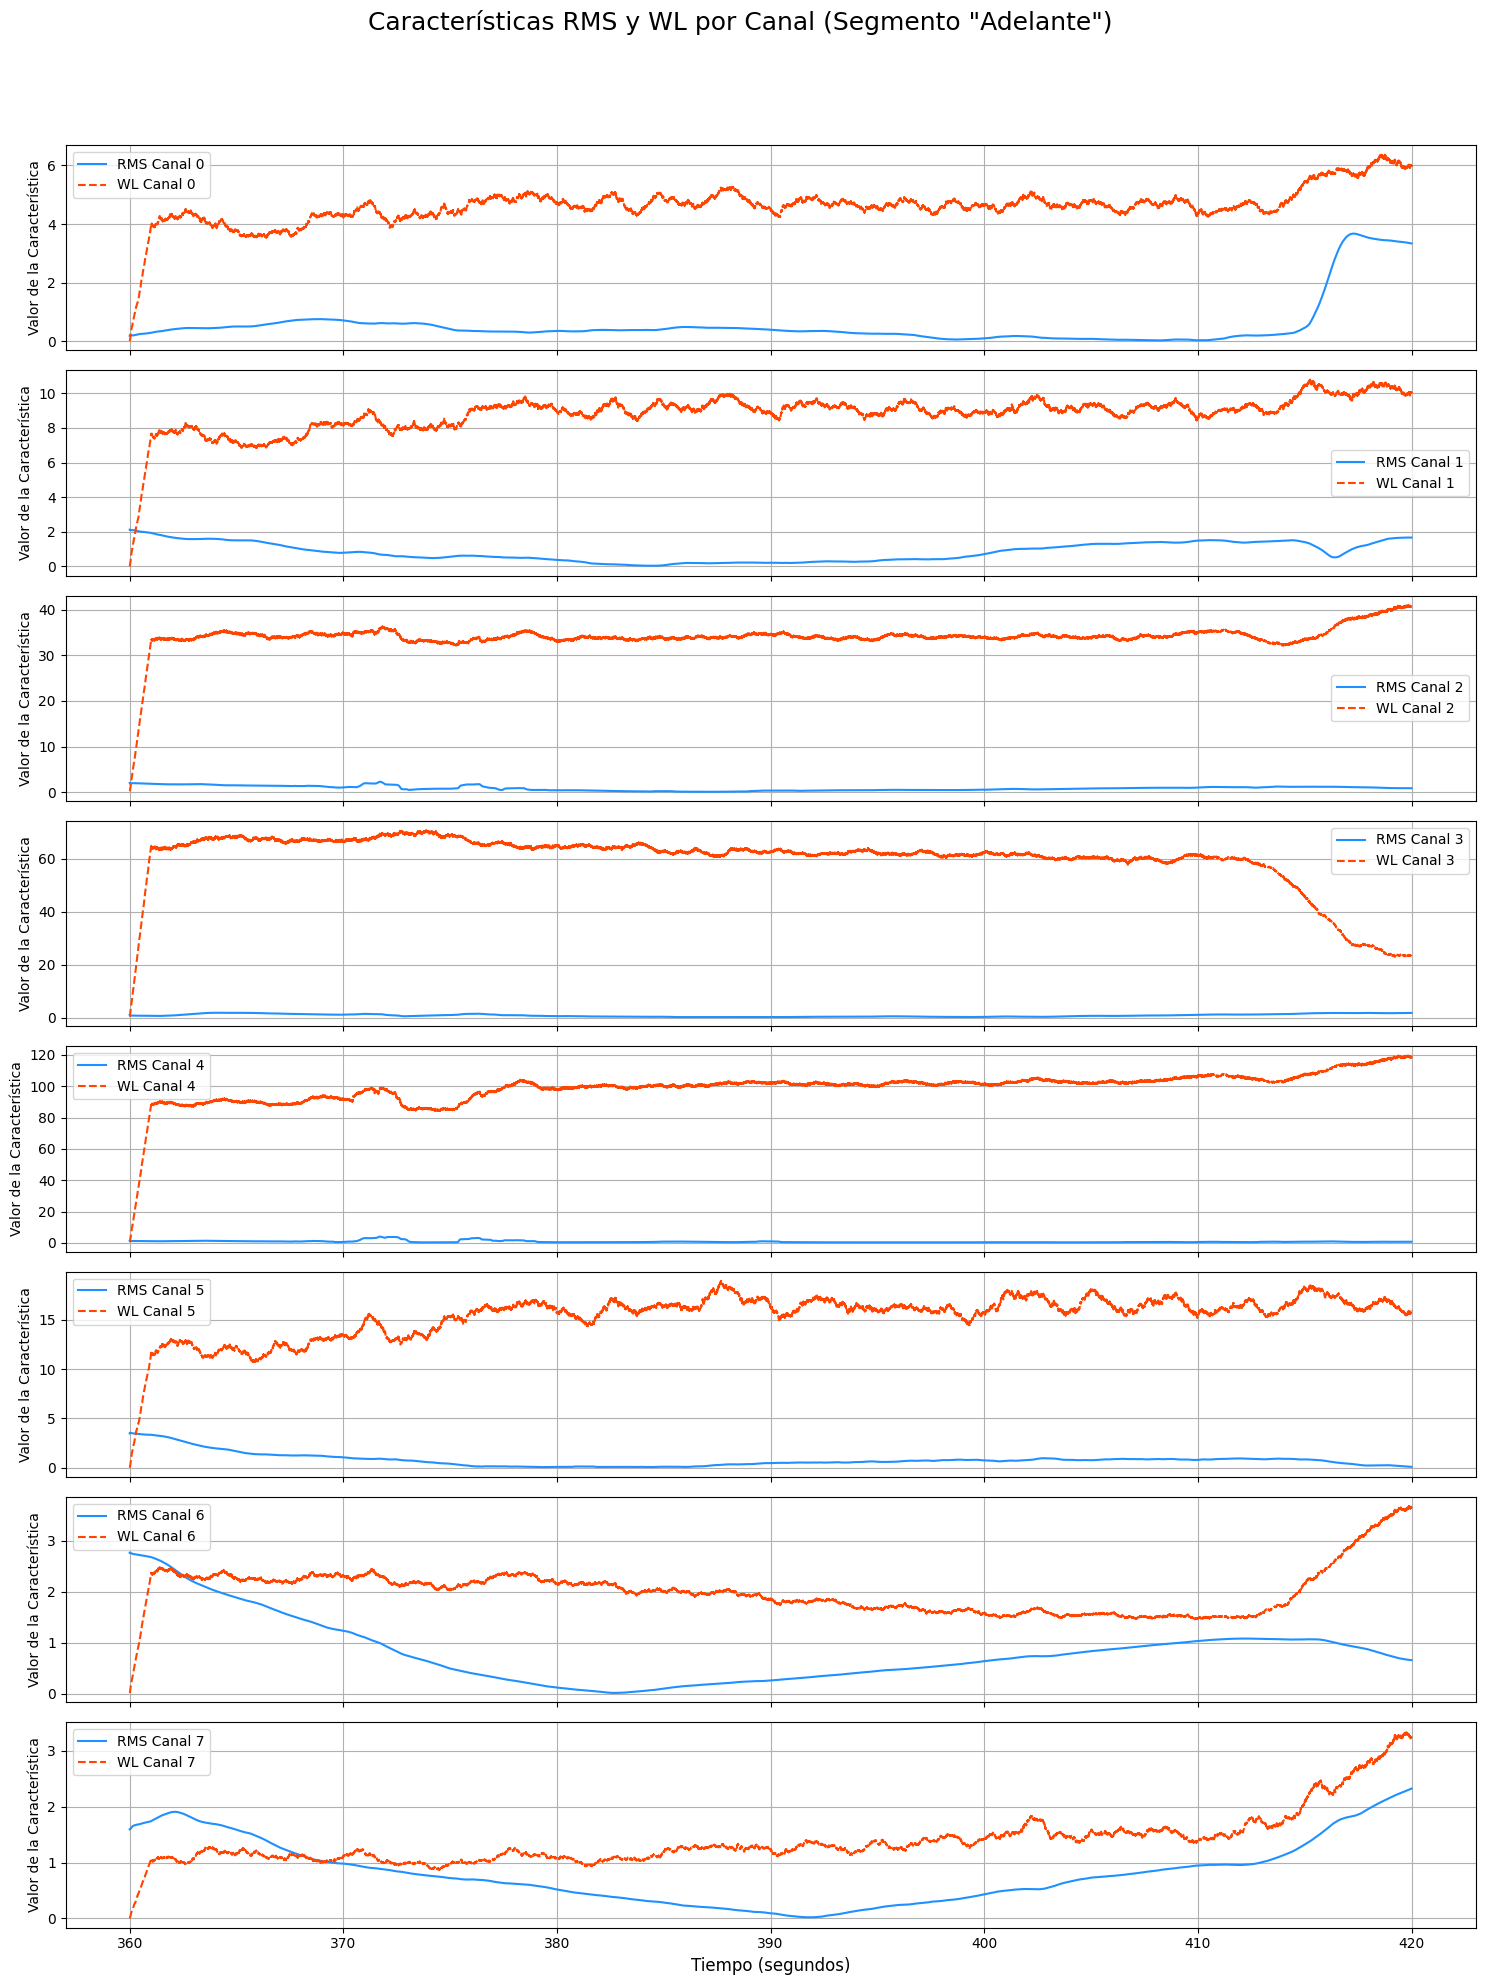

In [5]:
# --- Visualización de Características por Canal ---
# Vamos a usar el DataFrame del segmento 'adelante' que ya tiene las features calculadas
# (Asegúrate de haber corrido la celda que normaliza y calcula las features primero)

# Aplicamos la función para tener el DataFrame con características
df_adelante_features = calcular_features_rms_wl(dataframes['adelante'])


# Número de canales a graficar
num_channels = 8 # Asumiendo que tienes del canal 0 al 7

# Crear una figura con 8 subgráficos apilados verticalmente
fig, axes = plt.subplots(num_channels, 1, figsize=(15, 20), sharex=True)

# Título general para toda la figura
fig.suptitle('Características RMS y WL por Canal (Segmento "Adelante")', fontsize=18, y=1.02)

for i in range(num_channels):
    # Seleccionar el subgráfico (eje) actual
    ax = axes[i]
    
    # Nombres de las columnas para este canal
    rms_col = f'RMS_EXG Channel {i}'
    wl_col = f'WL_EXG Channel {i}'
    
    # Graficar RMS vs Tiempo
    ax.plot(df_adelante_features['time_seconds'], df_adelante_features[rms_col], label=f'RMS Canal {i}', color='dodgerblue')
    
    # Graficar WL vs Tiempo
    ax.plot(df_adelante_features['time_seconds'], df_adelante_features[wl_col], label=f'WL Canal {i}', color='orangered', linestyle='--')
    
    # Personalización de cada subgráfico
    ax.set_ylabel('Valor de la Característica')
    ax.grid(True)
    ax.legend()

# Añadir la etiqueta del eje X solo al último gráfico
axes[-1].set_xlabel('Tiempo (segundos)', fontsize=12)

# Ajustar el espaciado para que no se superpongan los títulos
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

In [6]:
lista_final_dfs = []

for clase, df in dataframes.items():
    print(f"Calculando características para: {clase}")
    
    # 1. Calcular características para el segmento actual
    df_con_features = calcular_features_rms_wl(df)
    
    # 2. Añadir la columna de clase
    df_con_features['Clase'] = clase
    
    # 3. Seleccionar SOLO las columnas que queremos conservar
    columnas_a_conservar = [col for col in df_con_features.columns if 'RMS_' in col or 'WL_' in col]
    columnas_a_conservar.append('Clase') # No nos olvidemos de la clase
    
    df_limpio = df_con_features[columnas_a_conservar]
    
    # 4. Añadir el DataFrame limpio a nuestra lista
    lista_final_dfs.append(df_limpio)

# --- Unificar todo en un solo DataFrame ---
df_final_features = pd.concat(lista_final_dfs, ignore_index=True)

# --- Limpiar los NaNs generados por .rolling() ---
df_final_features_limpio = df_final_features.dropna()

print("\n¡DataFrame final de características creado y limpiado!")

# --- Verificación Final ---
print(f"La forma del DataFrame final es: {df_final_features_limpio.shape}")
print("\nConteo de muestras por clase:")
print(df_final_features_limpio['Clase'].value_counts())
display(df_final_features_limpio.head())

Calculando características para: basal
Calculando RMS y WL para 8 canales...
¡Cálculo completado!
Calculando características para: adelante
Calculando RMS y WL para 8 canales...
¡Cálculo completado!
Calculando características para: atras
Calculando RMS y WL para 8 canales...
¡Cálculo completado!
Calculando características para: derecha
Calculando RMS y WL para 8 canales...
¡Cálculo completado!
Calculando características para: izquierda
Calculando RMS y WL para 8 canales...
¡Cálculo completado!
Calculando características para: reposo
Calculando RMS y WL para 8 canales...
¡Cálculo completado!

¡DataFrame final de características creado y limpiado!
La forma del DataFrame final es: (118825, 17)

Conteo de muestras por clase:
Clase
basal        30719
reposo       26670
adelante     15359
atras        15359
derecha      15359
izquierda    15359
Name: count, dtype: int64


,RMS_EXG Channel 0,WL_EXG Channel 0,RMS_EXG Channel 1,WL_EXG Channel 1,RMS_EXG Channel 2,WL_EXG Channel 2,RMS_EXG Channel 3,WL_EXG Channel 3,RMS_EXG Channel 4,WL_EXG Channel 4,RMS_EXG Channel 5,WL_EXG Channel 5,RMS_EXG Channel 6,WL_EXG Channel 6,RMS_EXG Channel 7,WL_EXG Channel 7,Clase
1,0.477403,0.166017,1.787390,0.030645,1.274388,0.196248,1.798903,0.021309,1.760000,0.214317,1.807076,0.170841,1.488721,0.038703,1.701189,0.013358,basal
2,0.417499,0.460141,1.775970,0.080385,1.288570,0.248499,1.789074,0.040272,1.727356,0.224884,1.737128,0.473302,1.487258,0.062324,1.710072,0.046561,basal
3,0.365154,0.617007,1.762906,0.110175,1.252969,0.425468,1.788176,0.056496,1.757744,0.410650,1.664513,0.636684,1.478468,0.094868,1.719996,0.068289,basal
4,0.344218,0.757926,1.759496,0.132848,1.231683,0.428539,1.793491,0.085614,1.782207,0.441615,1.647050,0.787313,1.476666,0.112522,1.722352,0.085972,basal
5,0.331372,0.772567,1.758975,0.143426,1.242027,0.578466,1.795587,0.094180,1.770546,0.607439,1.642655,0.832550,1.479052,0.134008,1.722540,0.094241,basal


In [7]:
# Asumo que la variable 'id_archivo' de la celda de carga de datos sigue disponible.
# Su valor debería ser algo como "_sujeto_02"

# 1. Construir el nombre del archivo final dinámicamente
path_final = f'../data/processed/final_feature_data{id_archivo}.parquet'

print(f"Guardando el DataFrame de características en: {path_final}")
# Asegúrate de usar el nombre correcto de tu DataFrame final y limpio
print(f"Forma del DataFrame a guardar: {df_final_features_limpio.shape}")

# 2. Guardar en formato Parquet
df_final_features_limpio.to_parquet(path_final)

print(f"\n¡Archivo de características para el sujeto '{id_archivo}' guardado exitosamente! ✅")

Guardando el DataFrame de características en: ../data/processed/final_feature_data_sujeto_03.parquet
Forma del DataFrame a guardar: (118825, 17)

¡Archivo de características para el sujeto '_sujeto_03' guardado exitosamente! ✅
